In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter

import pytz
import datetime
from statsmodels.regression.linear_model import RegressionResults
import statsmodels.api as sm
from statsmodels.formula.api import ols



### Question 1
Report the following statistics for each hashtag, i.e. each file:

• Average number of tweets per hour

• Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)

• Average number of retweets per tweet


In [7]:
tweetFiles = ["tweets/tweets_#gohawks.txt",
              "tweets/tweets_#gopatriots.txt",
              "tweets/tweets_#nfl.txt",
              "tweets/tweets_#patriots.txt",
              "tweets/tweets_#sb49.txt",
              "tweets/tweets_#superbowl.txt" ]

In [11]:
with open(tweetFiles[0], 'r') as tweetData:
    for line in tweetData:
        parsed = json.loads(line)
        print(json.dumps(parsed, indent=4, sort_keys=True))
        break

{
    "author": {
        "author_img": "http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg",
        "description": "Married to my best friend... You-make me laugh and occasionally think... I-will let you in on some of the crazy shit that consumes my thoughts...",
        "followers": 1752.0,
        "image_url": "http://pbs.twimg.com/profile_images/561716455155064833/XGrpP4Rl_normal.jpeg",
        "name": "RJ",
        "nick": "rejinseattle",
        "type": "twitter",
        "url": "http://twitter.com/rejinseattle"
    },
    "citation_date": 1421518778,
    "citation_url": "http://twitter.com/REJinseattle/status/556516209261166593",
    "firstpost_date": 1419804875,
    "highlight": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
    "metrics": {
        "acceleration": 0,
        "citations": {
            "data": [
                {
                    "citations": 1,
                    "timestamp": 1421518739
                }
            ],
  

In [14]:
for tweetFile in tweetFiles:
    
    timeStamp = []
    tweetCount = 0
    followerCount = 0
    retweetCount = 0
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            timeStamp.append(data['citation_date'])
            followerCount = followerCount + (data['author']['followers'])
            retweetCount = retweetCount + (data['metrics']['citations']['total'])
            tweetCount = tweetCount + 1
        
        print(tweetFile)
        print("Avg number of tweets per hour: ", str(tweetCount/((max(timeStamp)-min(timeStamp))/3600)))
        print("Avg number of followers of poster per tweet : ", str(followerCount/tweetCount))
        print("Avg number of rewteets per tweet: ", str(retweetCount/tweetCount))



tweets/tweets_#gohawks.txt
Avg number of tweets per hour:  292.48785062173687
Avg number of followers of poster per tweet :  2217.9237355281984
Avg number of rewteets per tweet:  2.0132093991319877
tweets/tweets_#gopatriots.txt
Avg number of tweets per hour:  40.95469800606194
Avg number of followers of poster per tweet :  1427.2526051635405
Avg number of rewteets per tweet:  1.4081919101697078
tweets/tweets_#nfl.txt
Avg number of tweets per hour:  397.0213901819841
Avg number of followers of poster per tweet :  4662.37544523693
Avg number of rewteets per tweet:  1.5344602655543254
tweets/tweets_#patriots.txt
Avg number of tweets per hour:  750.89426460689
Avg number of followers of poster per tweet :  3280.4635616550277
Avg number of rewteets per tweet:  1.7852871288476946
tweets/tweets_#sb49.txt
Avg number of tweets per hour:  1276.8570598680474
Avg number of followers of poster per tweet :  10374.160292019487
Avg number of rewteets per tweet:  2.52713444111402
tweets/tweets_#superbo

### Question 2
Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.

In [27]:
q2Files = ["tweets/tweets_#nfl.txt","tweets/tweets_#superbowl.txt"];

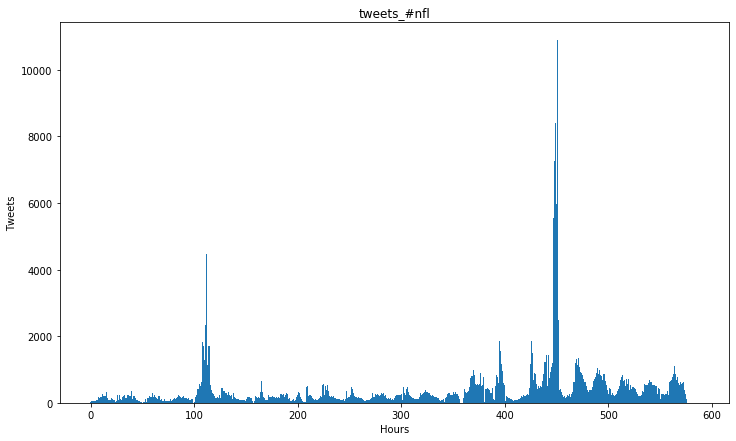

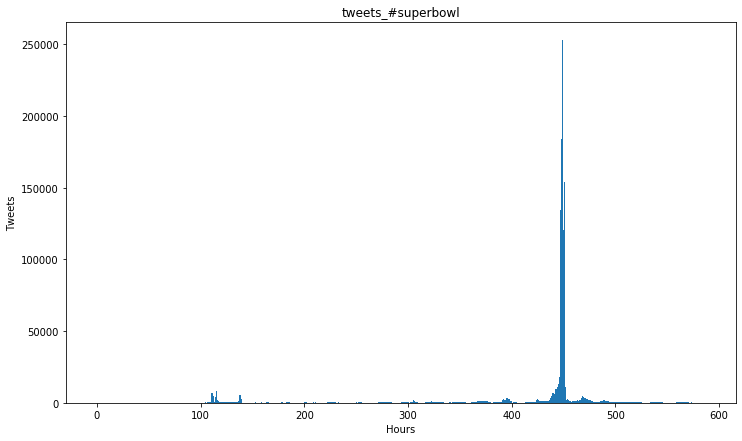

In [31]:
for tweetFile in q2Files:
    
    timeStamp = []
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            timeStamp.append(data['citation_date'])

        maxTime = max(timeStamp)
        minTime = min(timeStamp)
        timeStamp = np.rint((np.array(timeStamp) - minTime)/3600);

        plt.figure(figsize=(12,7))
        plt.bar(Counter(timeStamp).keys(), Counter(timeStamp).values(), width=1)
        plt.xlabel('Hours')
        plt.ylabel('Tweets')
        plt.title(tweetFile[7:-4])
        plt.show()



### Question 3
For each of your models, report your model’s Mean Squared Error (MSE) and R-squared measure. Also, analyse the significance of each feature using the t-test and p-value. You may use the OLS in the libarary statsmodels in Python.

In [38]:
tweetdf = []
for tweetFile in tweetFiles:
    
    tweetCount = []
    followerCount = []
    followerMaxCount = []
    retweetCount = []
    datePst = []
    hr = []
    
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            
            datePst.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz))
            
            hr.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz).hour)
            followerCount.append(data['author']['followers'])
            followerMaxCount.append(data['author']['followers'])
            retweetCount.append(data['metrics']['citations']['total'])
            tweetCount.append(1)
            
        d = {'followerCount': followerCount, 'followerMaxCount': followerMaxCount, 'retweetCount' : retweetCount,
            'tweetCount' : tweetCount, 'hr' : hr, 'datePst' : datePst}
        tweetdf.append(pd.DataFrame(data=d))


In [60]:
mse1 = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr", data=tweetGroup).fit()
    print(tweetFiles[i][7:-4])
    print(model.summary())
    mse1.append((tweetFiles[i][7:-4],model.mse_resid))
    print("MSE:",model.mse_resid)


tweets_#gohawks
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     102.3
Date:                Sun, 15 Mar 2020   Prob (F-statistic):           1.10e-76
Time:                        02:48:26   Log-Likelihood:                -4663.7
No. Observations:                 569   AIC:                             9339.
Df Residuals:                     563   BIC:                             9365.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           99.5

tweets_#sb49
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     435.6
Date:                Sun, 15 Mar 2020   Prob (F-statistic):          4.54e-185
Time:                        02:48:26   Log-Likelihood:                -5231.3
No. Observations:                 536   AIC:                         1.047e+04
Df Residuals:                     530   BIC:                         1.050e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          235.0748

In [61]:
for i in np.arange(len(mse1)):
    print(mse1[i])

('tweets_#gohawks', 778598.8815298494)
('tweets_#gopatriots', 36467.25983218669)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.51812663)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051509)


### Question 4
Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

In [85]:
tweetdf = []
for tweetFile in tweetFiles:
    
    tweetCount = []
    followerCount = []
    followerMaxCount = []
    retweetCount = []
    datePst = []
    hr = []
    
    userMentions = []
    rankScore = []
    hashTags = []
    
    utc_tz = pytz.UTC
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    with open(tweetFile, 'r', encoding='utf8') as tweetData:
        for line in tweetData:
            
            data = json.loads(line)
            
            datePst.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz))
            
            hr.append(datetime.datetime.fromtimestamp(data['citation_date'], pst_tz).hour)
            followerCount.append(data['author']['followers'])
            followerMaxCount.append(data['author']['followers'])
            retweetCount.append(data['metrics']['citations']['total'])
            tweetCount.append(1)
            
            userMentions.append(len(data['tweet']['entities']['user_mentions']))
            rankScore.append(data['metrics']['ranking_score'])
            hashTags.append(len(data['tweet']['entities']['hashtags']))
            
        d = {'followerCount': followerCount, 'followerMaxCount': followerMaxCount, 'retweetCount' : retweetCount,
            'tweetCount' : tweetCount, 'hr' : hr, 'datePst' : datePst,
            'userMentions' : userMentions, 'rankScore' : rankScore, 'hashTags' : hashTags}
        tweetdf.append(pd.DataFrame(data=d))

In [86]:
mse2 = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=tweetGroup).fit()
    print(tweetFiles[i][7:-4])
    print(model.summary())
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    print("MSE:",model.mse_resid)

tweets_#gohawks
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     113.3
Date:                Sun, 15 Mar 2020   Prob (F-statistic):          7.46e-112
Time:                        03:22:24   Log-Likelihood:                -4573.7
No. Observations:                 569   AIC:                             9165.
Df Residuals:                     560   BIC:                             9204.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -67.7

tweets_#sb49
                            OLS Regression Results                            
Dep. Variable:                 future   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     357.3
Date:                Sun, 15 Mar 2020   Prob (F-statistic):          2.56e-207
Time:                        03:22:24   Log-Likelihood:                -5169.9
No. Observations:                 536   AIC:                         1.036e+04
Df Residuals:                     527   BIC:                         1.040e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -110.8140

In [87]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print(mse2[i])

('tweets_#gohawks', 778598.8815298494)
('tweets_#gopatriots', 36467.25983218669)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.51812663)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051509)


('tweets_#gohawks', 570499.3512646803)
('tweets_#gopatriots', 16564.97294026522)
('tweets_#nfl', 238488.0340183977)
('tweets_#patriots', 3001880.2254958726)
('tweets_#sb49', 14216513.1612403)
('tweets_#superbowl', 31617569.980573352)


### Question 5
For each of the top 3 features (i.e. with the smallest p-values) in your measurements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it. Do the regression coefficients agree with the trends in the plots? If not, why?

tweets_#gohawks


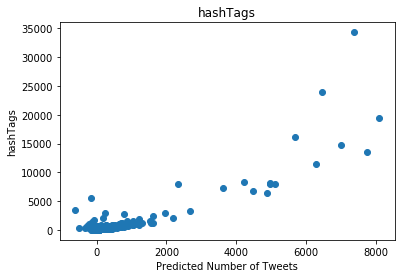

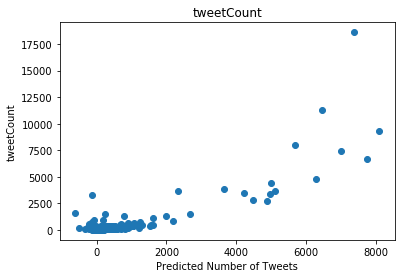

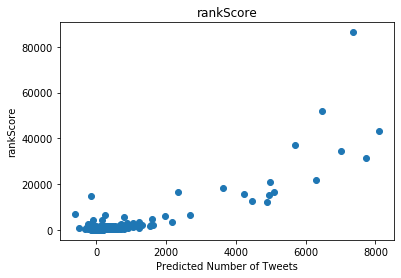

tweets_#gopatriots


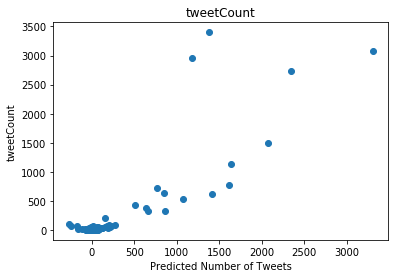

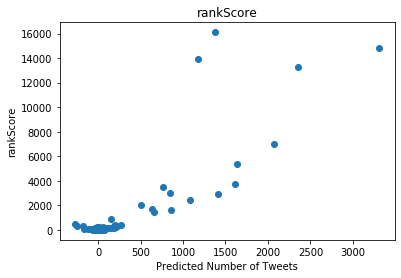

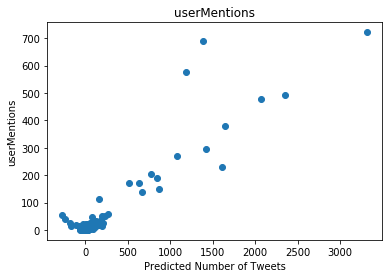

tweets_#nfl


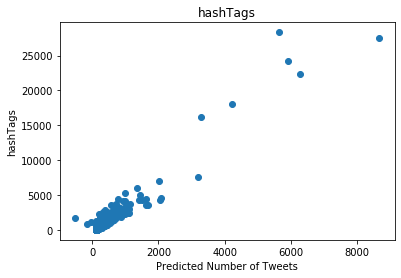

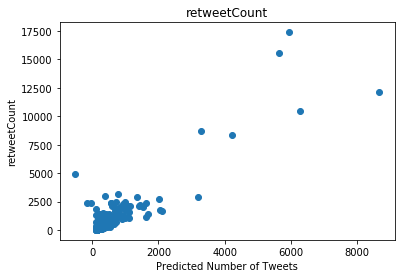

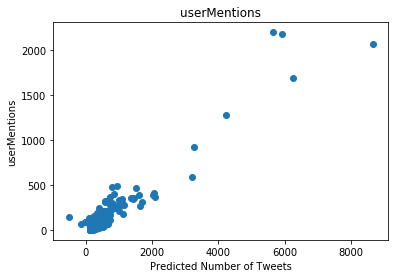

tweets_#patriots


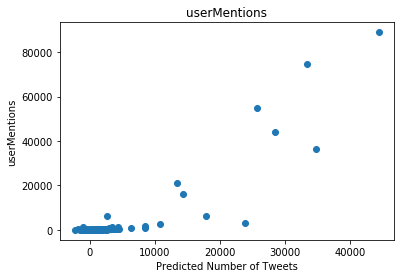

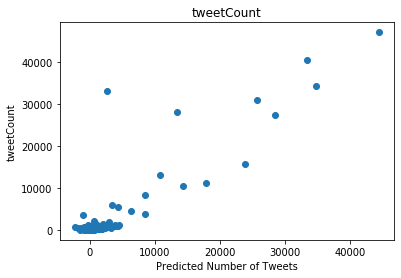

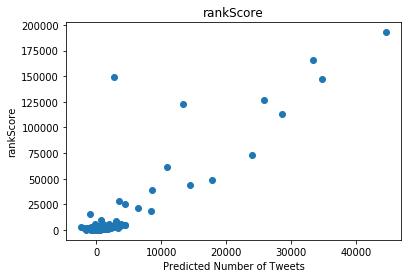

tweets_#sb49


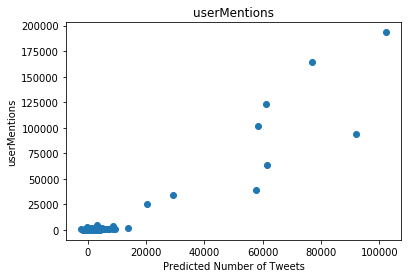

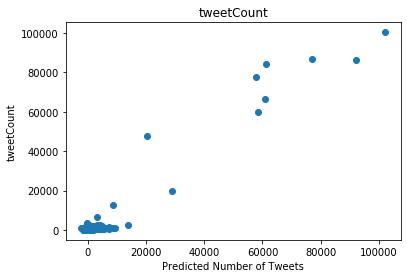

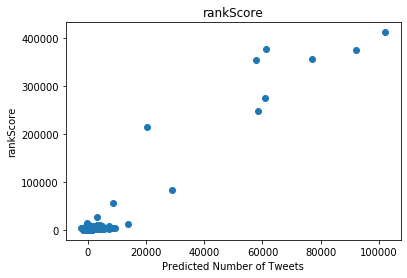

tweets_#superbowl


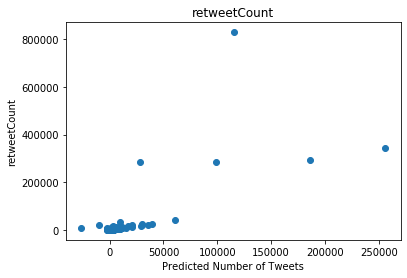

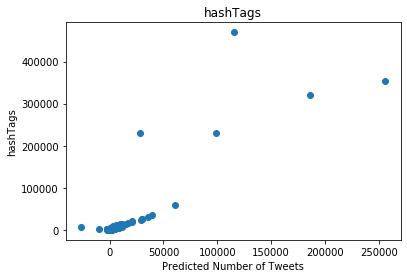

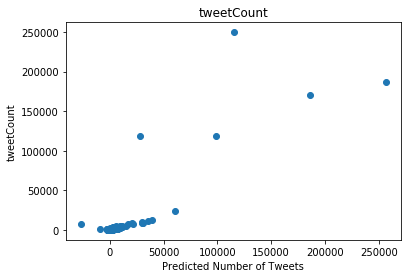

In [117]:
features = ['followerCount','followerMaxCount','retweetCount','tweetCount','hr',
        'userMentions','rankScore','hashTags']
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=tweetGroup).fit()
    predict = model.predict(tweetGroup)
    
    print(tweetFiles[i][7:-4])
    
    featuresSorted = []
    pVals = model.pvalues[1:]
    for j in np.arange(len(features)):
        featuresSorted.append((pVals[j], features[j]))
    featuresSorted.sort(key = lambda x: x[0]) 

    for j in np.arange(3):
        plt.scatter(predict, tweetGroup[featuresSorted[j][1]])
        plt.title(featuresSorted[j][1])
        plt.xlabel("Predicted Number of Tweets")
        plt.ylabel(featuresSorted[j][1])
        plt.show()
    

### Question 6
We define three time periods and their corresponding window length as follows:
1. Before Feb. 1, 8:00 a.m.: 1-hour window
2. Between Feb. 1, 8:00 a.m. and 8:00 p.m.: 5-minute window
3. After Feb. 1, 8:00 p.m.: 1-hour window


In [147]:
## P1
mse2 = []
rsquare = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] < '2015-02-01 08:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=tweetGroup).fit()
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    rsquare.append(model.rsquared)

In [148]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print("MSE: " + str(mse2[i]) + " R2 " + str(rsquare[i]))

('tweets_#gohawks', 778598.8815298494)
('tweets_#gopatriots', 36467.25983218669)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.51812663)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051509)


MSE: ('tweets_#gohawks', 429750.53799418645) R2 0.5916850979811367
MSE: ('tweets_#gopatriots', 1474.0471232305451) R2 0.6914123354033186
MSE: ('tweets_#nfl', 65350.36716153126) R2 0.52583856014154
MSE: ('tweets_#patriots', 319422.02567651076) R2 0.5995411761973746
MSE: ('tweets_#sb49', 6450.223559481974) R2 0.8897230986245016
MSE: ('tweets_#superbowl', 492762.4129146807) R2 0.44066917425334806


In [149]:
## P2
mse2 = []
rsquare = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] >= '2015-02-01 08:00:00-0800') &
                       (tweetdf[i]['datePst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=tweetGroup).fit()
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    rsquare.append(model.rsquared)

In [150]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print("MSE: " + str(mse2[i]) + " R2 " + str(rsquare[i]))

('tweets_#gohawks', 778598.8815298494)
('tweets_#gopatriots', 36467.25983218669)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.51812663)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051509)


MSE: ('tweets_#gohawks', 71867.87318303817) R2 0.5252941394071905
MSE: ('tweets_#gopatriots', 14111.243484480658) R2 0.4950321571183708
MSE: ('tweets_#nfl', 19941.203895562103) R2 0.8382421614128912
MSE: ('tweets_#patriots', 670288.5382942321) R2 0.72902839299682
MSE: ('tweets_#sb49', 1194505.5546879158) R2 0.8835141093642394
MSE: ('tweets_#superbowl', 5344357.288608209) R2 0.9198009093840809


In [151]:
## P3
mse2 = []
rsquare = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] >= '2015-02-01 20:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    
    model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=tweetGroup).fit()
    mse2.append((tweetFiles[i][7:-4],model.mse_resid))
    rsquare.append(model.rsquared)

In [146]:
for i in np.arange(len(mse1)):
    print(mse1[i])
print("\n")
for i in np.arange(len(mse2)):
    print("MSE: " + str(mse2[i]) + " R2 " + str(rsquare[i]))

('tweets_#gohawks', 778598.8815298494)
('tweets_#gopatriots', 36467.25983218669)
('tweets_#nfl', 274541.22223045497)
('tweets_#patriots', 5234485.51812663)
('tweets_#sb49', 17774930.5906947)
('tweets_#superbowl', 53026404.70051509)


MSE: ('tweets_#gohawks', 1924.41328997262) R2 0.84971686708285
MSE: ('tweets_#gopatriots', 97.67336255472824) R2 0.7947150855994947
MSE: ('tweets_#nfl', 17565.966312820066) R2 0.7983639105713036
MSE: ('tweets_#patriots', 11465.262152121803) R2 0.88108013272112
MSE: ('tweets_#sb49', 48731.29957923046) R2 0.876014903368591
MSE: ('tweets_#superbowl', 110146.11816769073) R2 0.8555680823198912


### Question 7
Also, aggregate the data of all hashtags, and train 3 models (for the intervals mentioned above) to predict the number of tweets in the next time window on the aggregated data.

Perform the same evaluations on your combined model and compare with models you trained for individual hashtags.


In [191]:
## P1
combinedTweetGroupDf = []
combinedTweetGroupDfTruth = []
combinedTweetGroupDfPredict = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] < '2015-02-01 08:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDf.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 08:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 09:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfTruth.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 07:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 08:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfPredict.append(tweetGroup)

combinedTweetGroup = pd.concat(combinedTweetGroupDf)
combinedTweetGroupTruth = pd.concat(combinedTweetGroupDfTruth)
combinedTweetGroupPredict = pd.concat(combinedTweetGroupDfPredict)

model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=combinedTweetGroup).fit()

print("Predicted: ")
print(model.predict(combinedTweetGroupPredict))
print("Truth: ")
print(combinedTweetGroupTruth['tweetCount'])

Predicted: 
datePst
2015-02-01 07:00:00-08:00     266.332378
2015-02-01 07:00:00-08:00      95.007333
2015-02-01 07:00:00-08:00    1112.269220
2015-02-01 07:00:00-08:00     700.226909
2015-02-01 07:00:00-08:00    1822.545105
2015-02-01 07:00:00-08:00    5196.176430
dtype: float64
Truth: 
datePst
2015-02-01 08:00:00-08:00     231
2015-02-01 08:00:00-08:00      31
2015-02-01 08:00:00-08:00     847
2015-02-01 08:00:00-08:00     435
2015-02-01 08:00:00-08:00    1629
2015-02-01 08:00:00-08:00    5031
Freq: 60T, Name: tweetCount, dtype: int64


In [192]:
## P2
combinedTweetGroupDf = []
combinedTweetGroupDfTruth = []
combinedTweetGroupDfPredict = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] >= '2015-02-01 08:00:00-0800') &
                       (tweetdf[i]['datePst'] <= '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDf.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 20:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 20:05:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfTruth.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-01 19:55:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-01 20:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='5Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfPredict.append(tweetGroup)

combinedTweetGroup = pd.concat(combinedTweetGroupDf)
combinedTweetGroupTruth = pd.concat(combinedTweetGroupDfTruth)
combinedTweetGroupPredict = pd.concat(combinedTweetGroupDfPredict)

model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=combinedTweetGroup).fit()

print("Predicted: ")
print(model.predict(combinedTweetGroupPredict))
print("Truth: ")
print(combinedTweetGroupTruth['tweetCount'])

Predicted: 
datePst
2015-02-01 19:55:00-08:00    365.166773
2015-02-01 19:55:00-08:00    354.648465
2015-02-01 19:55:00-08:00    379.376916
2015-02-01 19:55:00-08:00    380.559267
2015-02-01 19:55:00-08:00    403.048833
2015-02-01 19:55:00-08:00    976.815456
dtype: float64
Truth: 
datePst
2015-02-01 20:00:00-08:00     33
2015-02-01 20:00:00-08:00      7
2015-02-01 20:00:00-08:00     27
2015-02-01 20:00:00-08:00    148
2015-02-01 20:00:00-08:00    241
2015-02-01 20:00:00-08:00    194
Freq: 5T, Name: tweetCount, dtype: int64


In [200]:
## P3
combinedTweetGroupDf = []
combinedTweetGroupDfTruth = []
combinedTweetGroupDfPredict = []
for i in np.arange(len(tweetdf)):
    
    tweetGroup = tweetdf[i][tweetdf[i]['datePst'] >= '2015-02-01 20:00:00-0800'].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDf.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-07 10:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-07 11:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfTruth.append(tweetGroup)
    
    tweetGroup = tweetdf[i][(tweetdf[i]['datePst'] > '2015-02-07 10:00:00-0800') 
                            & (tweetdf[i]['datePst'] < '2015-02-07 11:00:00-0800')].groupby(pd.Grouper(key='datePst',freq='60Min')).agg({
        'followerCount':'sum',
        'followerMaxCount':'max',
        'retweetCount':'sum',
        'tweetCount':'sum',
        'hr':'max',
        'userMentions':'sum',
        'rankScore':'sum',
        'hashTags':'sum'})
    tweetGroup['future'] = tweetGroup['tweetCount']
    tweetGroup.future = tweetGroup.future.shift(-1)
    combinedTweetGroupDfPredict.append(tweetGroup)

combinedTweetGroup = pd.concat(combinedTweetGroupDf)
combinedTweetGroupTruth = pd.concat(combinedTweetGroupDfTruth)
combinedTweetGroupPredict = pd.concat(combinedTweetGroupDfPredict)

model = ols("future ~ followerCount + followerMaxCount + retweetCount + tweetCount + hr + userMentions + rankScore + hashTags", data=combinedTweetGroup).fit()

print("Predicted: ")
print(model.predict(combinedTweetGroupPredict))
print("Truth: ")
print(combinedTweetGroupTruth['tweetCount'])

Predicted: 
datePst
2015-02-07 10:00:00-08:00    29.777283
2015-02-07 10:00:00-08:00    32.736918
2015-02-07 10:00:00-08:00    62.212445
2015-02-07 10:00:00-08:00    29.767759
dtype: float64
Truth: 
datePst
2015-02-07 10:00:00-08:00     5
2015-02-07 10:00:00-08:00     3
2015-02-07 10:00:00-08:00    43
2015-02-07 10:00:00-08:00     1
Name: tweetCount, dtype: int64
